In [34]:
# %matplotlib inline
# %matplotlib notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d as mpl3d
from matplotlib import cm
from scipy import signal
from scipy import stats
from scipy import linalg
from scipy import fft
from scipy import io
import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(123)

In [51]:
class Util:
    def __init(self):
        pass

    @classmethod
    def round_power2(self, x):
        assert x > 0.
        assert not np.iscomplex(x)
        return int(np.power(2., np.ceil(np.log2(x))))

    @classmethod
    def sample_time(self, f_sample, n):
        assert n > 0, 'n must be greater than 0'
        assert f_sample > 0.
        return n / f_sample

    @classmethod
    def dB_power(self, x):
        assert x > 0
        assert not np.iscomplex(x)
        return 10. * np.log10(x)

    @classmethod
    def dB(self, x):
        assert x > 0
        assert not np.iscomplex(x)
        return 20. * np.log10(x)

    @classmethod
    def dB_to_factor_power(self, x):
        assert not np.iscomplex(x)
        return 10.**(x / 10.)

    @classmethod
    def dB_to_factor(self, x):
        assert not np.iscomplex(x)
        return 10.**(x / 20.)

    @classmethod
    def signal_power(self, x, dB=True):
        assert x.ndim == 1
        p = np.sum(np.abs(x)**2.) / len(x)
        if dB:
            return self.dB_power(p)
        else:
            return p

    @classmethod
    def signal_energy(self, x, length):
        assert x.ndim == 1, 'signal must have 1 dimension'
        assert length > 0, 'time length must be greater than 0'
        return self.signal_power(x) * length

    @classmethod
    def snr(self, x, y, dB=True):
        assert x.ndim == 1
        assert y.ndim == 1
        snr = self.signal_power(x, dB=False) / self.signal_power(y, dB=False)
        if dB:
            return self.dB_power(snr)
        else:
            return snr
    
    @classmethod
    def get_signal_length(self, fs, seconds):
        assert fs > 0. and seconds > 0. 
        return fs * seconds


class WirelessMicrophone:
    def __init__(self, f_sample=1000.0, num_samples=None, t_sec=None):
        assert f_sample > 0, 'must be greater than 0'
        if num_samples is not None:
            assert num_samples > 0, 'must be greater than 0'
            self.f_sample = f_sample
            self.num_samples = int(num_samples)
            self.t_sec = self.num_samples / self.f_sample
        elif t_sec is not None:
            assert t_sec > 0, 'must be greater than 0'
            self.f_sample = f_sample
            self.t_sec = t_sec
            self.num_samples = int(self.t_sec * self.f_sample)
        else:
            assert False, 'either num_samples or t_sec needed'

    def get_signal(self, f_center, f_deviation, f_modulation, dB=0.):
        t = np.arange(self.num_samples) / self.f_sample
        x = np.exp(1.j *
                   (2. * np.pi * f_center * t + f_deviation / f_modulation *
                    np.sin(2. * np.pi * f_modulation * t)))
        x -= np.mean(x)  # normalize signal
        x /= np.std(x)  # ^
        x *= 10.**(dB / 20.)
        return x

    def get_silent(self, f_center, dB=0.):
        return self.get_signal(f_center, 5000, 32000, dB)

    def get_soft(self, f_center, dB=0.):
        return self.get_signal(f_center, 3900, 15000, dB)

    def get_loud(self, f_center, dB=0.):
        return self.get_signal(f_center, 13400, 32600, dB)


class WhiteGaussianNoise:
    def __init__(self, f_sample=1000.0, n=None, t_sec=None):
        assert f_sample > 0, 'must be greater than 0'
        if n is not None:
            assert n > 0, 'must be greater than 0'
            self.f_sample = f_sample
            self.n = int(n)
            self.t_sec = self.n / self.f_sample
        elif t_sec is not None:
            assert t_sec > 0, 'must be greater than 0'
            self.f_sample = f_sample
            self.t_sec = t_sec
            self.n = int(self.t_sec * self.f_sample)
        else:
            assert False, 'either n or t_sec needed'

    def get_signal(self, dB=0.):
        x = 10.**(dB / 10.)
        x = stats.multivariate_normal(mean=[0., 0.],
                                      cov=[[.5 * x, 0.], [0., .5 * x]])
        x = x.rvs(size=self.n).view(np.complex128).reshape(self.n)
        return x


sample_frequency = 1e6  # in Hz
length = 1.0  # in s
signal_strength = 0.0  # in dB
noise_strength = 0.0  # in dB

wm = WirelessMicrophone(f_sample=sample_frequency, t_sec=length)
# wm = WirelessMicrophone(f_sample=sample_frequency, num_samples=1e5)
sig = wm.get_signal(f_center=1e5,
                    f_deviation=15000,
                    f_modulation=3900,
                    dB=signal_strength)

wgn = WhiteGaussianNoise(f_sample=sample_frequency, t_sec=length)
noise = wgn.get_signal(dB=noise_strength)

both = sig + noise

print(f'wm.f_sample     {wm.f_sample}')
print(f'wm.nnum_samples {wm.num_samples}')
print(f'wm.t_sec        {wm.t_sec}')

num_samples = wm.num_samples
sample_freq = wm.f_sample

print('Signal power: %6.2f dB' % (Util.signal_power(sig, dB=True)))
print('Noise power: %7.2f dB' % (Util.signal_power(noise, dB=True)))
print('SNR: %15.2f dB' % (Util.snr(sig, noise, dB=True)))
print(f'Mean            {np.abs(noise.mean())}')
print(f'Var             {np.abs(noise.var())}')

wm.f_sample     1000000.0
wm.nnum_samples 1000000
wm.t_sec        1.0
Signal power:   0.00 dB
Noise power:   -0.01 dB
SNR:            0.01 dB
Mean            0.0007597816344194624
Var             0.9979034732495526


In [36]:
# Matplotlib Spectogram

# plt.figure(figsize=(8, 6))
# plt.specgram(noise,
#              NFFT=1024,
#              Fs=sample_freq,
#              scale='dB',
#              cmap='viridis',
#              noverlap=0,
#              mode='psd',
#              window=signal.get_window('hann', 1024))
# plt.title("PSD")
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.specgram(sig,
#              NFFT=1024,
#              Fs=sample_freq,
#              scale='dB',
#              cmap='viridis',
#              noverlap=0,
#              mode='psd',
#              window=signal.get_window('hann', 1024))
# plt.title("PSD")
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.specgram(both,
#              NFFT=1024,
#              Fs=sample_freq,
#              scale='dB',
#              cmap='viridis',
#              noverlap=0,
#              mode='psd',
#              window=signal.get_window('hann', 1024))
# plt.title("PSD")
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.show()

In [37]:
class TimeED():
    def __init__(self):
        pass
    
    @classmethod
    def get(self, x):
        return np.sum(np.abs(x) ** 2.)

en_sig = TimeED.get(sig)
print(f'Energy signal {en_sig}')
en_both = TimeED.get(both)
print(f'Energy both   {en_both}')

Energy signal 1000.0
Energy both   10670.364350221664


In [38]:
class CLTStats():
    def __init__(self):
        pass
        
    @classmethod
    def get_thr(self, noise_power, p_fa, n):
        return Util.signal_power(noise, dB=False)*(stats.norm.isf(p_fa)*np.sqrt(2.*n)+n)
    
    @classmethod
    def get_pfa(self):
        pass
    
    @classmethod
    def get_pd(self):
        pass
    
    @classmethod
    def get_roc(self):
        pass
    
class Chi2Stats():
    def __init__(self):
        pass
    
    @classmethod
    def get_thr(self, noise_power, pfa, n):
        return stats.chi2.ppf(1.-pfa, 2.*n)*noise_power/2.
    
    @classmethod
    def get_pfa(self, noise_power, thr, n):
        return 1. - stats.chi2.cdf(2.*thr/noise_power, 2.*n)
    
    @classmethod
    def get_pd(self, noise_power, signal_power, thr, n):
        return 1. - stats.chi2.cdf(2.*thr/(noise_power+signal_power), 2.*n)
    
    @classmethod
    def get_roc(self, noise_power=None, signal_power=None, snr=None, pfa=None, n=None):
        if snr is not None:
            snr = snr
        elif noise_power is not None and signal_power is not None:
            snr = signal_power/noise_power
        else:
            assert False, 'either supply snr or signal and noise power'
        return 1. - stats.chi2.cdf(stats.chi2.ppf(1.-pfa, 2.*n)/(1+signal_power/noise_power), 2.*n)

thr = Chi2Stats.get_thr(Util.dB_to_factor_power(10.), 0.1, num_samples)
print(f'thr {thr}')
    
pfa = Chi2Stats.get_pfa(1., thr, num_samples)
print(f'pfa {pfa}')

pd = Chi2Stats.get_pd(1., 0.001, thr, num_samples)
print(f'pd {pd}')

# pfa_roc = np.linspace(0., 1., 100)
# plt.figure(figsize=(8, 6))
# pd_roc = Chi2Stats.get_roc(noise_power=1., signal_power=0.001, pfa=pfa_roc, n=num_samples)
# plt.plot(pfa_roc, pd_roc)
# pd_roc = Chi2Stats.get_roc(noise_power=1., signal_power=0.002, pfa=pfa_roc, n=num_samples)
# plt.plot(pfa_roc, pd_roc)
# pd_roc = Chi2Stats.get_roc(noise_power=1., signal_power=0.0003, pfa=pfa_roc, n=num_samples)
# plt.plot(pfa_roc, pd_roc)
# plt.show()



thr 10407.3430801369
pfa 0.0
pd 0.0


   infs left at  0.00%
 50.00s left at  0.33%
 53.11s left at  0.67%
 48.08s left at  1.00%
 49.20s left at  1.33%
 60.62s left at  1.67%
 62.33s left at  2.00%
 47.49s left at  2.33%
 52.69s left at  2.67%
 61.91s left at  3.00%
 47.80s left at  3.33%
 47.64s left at  3.67%
 44.71s left at  4.00%
 47.65s left at  4.33%
 49.23s left at  4.67%
 48.78s left at  5.00%
 47.14s left at  5.33%
 47.13s left at  5.67%
 45.44s left at  6.00%
 47.91s left at  6.33%
 43.78s left at  6.67%
 46.89s left at  7.00%
 42.21s left at  7.33%
 43.88s left at  7.67%
 42.60s left at  8.00%
 43.69s left at  8.33%
 42.85s left at  8.67%
 43.99s left at  9.00%
 42.06s left at  9.33%
 44.28s left at  9.67%
 61.14s left at 10.00%
 66.82s left at 10.33%
 49.09s left at 10.67%
 46.12s left at 11.00%
 40.49s left at 11.33%
 41.25s left at 11.67%
 42.35s left at 12.00%
 45.10s left at 12.33%
 41.70s left at 12.67%
 42.34s left at 13.00%
 46.37s left at 13.33%
 50.79s left at 13.67%
 41.06s left at 14.00%
 40.82s lef

/home/fabian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invalid value encountered in double_scalars


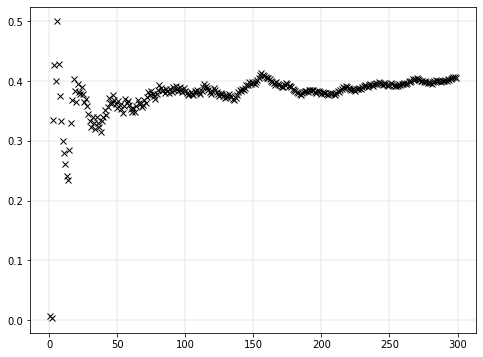

In [39]:
class MonteCarloSim():
    def __init__(self, m, n):
        self.m = m
        self.n = n
        self.reset()

    def reset(self):
        self.pfas = list()
        self.pds = list()
        self.time = None

    def run(self, signal_strength, noise_strength):
        sample_frequency = 1e6  # in Hz
        length = 0.001  # in s
        self.reset()
        thr = Chi2Stats.get_thr(
            noise_power=Util.dB_to_factor_power(noise_strength),
            pfa=0.1,
            n=Util.get_signal_length(fs=sample_frequency, seconds=length))
#         print(thr)
#         thr = 10407.343

        for i in range(self.m):
            wm = WirelessMicrophone(f_sample=sample_frequency, t_sec=length)
            wgn = WhiteGaussianNoise(f_sample=sample_frequency, t_sec=length)
            pfa_tmp, pd_tmp = self.iteration(wm, wgn, signal_strength,
                                             noise_strength, thr)
            self.pfas.append(pfa_tmp)
            self.pds.append(pd_tmp)
            rem, per = self.runtime_stats(self.m, i)
            print('%6.2fs left at %5.2f%%' % (rem, per))
        pfa = np.sum(self.pfas) / self.m
        pd = np.sum(self.pds) / self.m
        return pfa, pd

    def iteration(self, wm, wgn, signal_strengh, noise_strength, thr):

        correct_hit = 0
        false_hit = 0
        correct_miss = 0
        false_miss = 0

        times_signal_present = 0
        
        noise_uncertainty = np.random.uniform(-1., 1.)
        
        for i in range(self.n):
            sig = wm.get_signal(f_center=1e5,
                                f_deviation=15000,
                                f_modulation=3900,
                                dB=signal_strength)
            noise = wgn.get_signal(dB=noise_strength+noise_uncertainty)

            sig_present = bool(np.random.randint(2))
            if sig_present:
                both = sig + noise
                times_signal_present += 1
            else:
                both = noise

            eng = TimeED.get(both)
            sig_detected = eng > thr

            if sig_present and sig_detected:
                correct_hit += 1
            elif sig_present and not sig_detected:
                false_miss += 1
            elif not sig_present and sig_detected:
                false_hit += 1
            else:
                correct_miss += 1

        pfa = false_hit / (self.n - times_signal_present)
        pd = correct_hit / times_signal_present
        return pfa, pd

    def runtime_stats(self, total_itr, current_itr):
        if self.time is None:
            self.time = time.time()
            return float('inf'), 0.0
        delta_time = time.time() - self.time
        self.time = time.time()
        remaining_itr = total_itr - current_itr
        remaining_time = delta_time * remaining_itr
        percent_done = current_itr / total_itr * 100.0
        return remaining_time, percent_done

    def print_convergence(self):
        plt.figure(figsize=(8, 6))
        plt.grid(linewidth=0.3)
        for i in range(self.m):
            inter = np.sum(self.pfas[0:i]) / i
            plt.plot(i, inter, 'kx')
        plt.show()


sim = MonteCarloSim(300, 300)
pfa, pd = sim.run(signal_strength=0., noise_strength=10.)

print(f'pfa {pfa}')
print(f'pd {pd}')
sim.print_convergence()

In [40]:
# 0.1 -> 0.026
# 0.1 -> 0.016

# window_size = 1024

# sig1 = sig[0:1024]
# plt.figure(figsize=(8, 6))
# f_welch, psd_welch = signal.welch(sig1,
#                                   fs,
#                                   window='flattop',
#                                   nperseg=window_size,
#                                   noverlap=0,
#                                   nfft=window_size,
#                                   detrend=False,
#                                   scaling='density',
#                                   return_onesided=False)
# f_welch = fft.fftshift(f_welch)
# psd_welch = fft.fftshift(psd_welch)
# plt.figure(figsize=(8, 6))
# # plt.semilogy(f_welch, psd_welch)
# plt.plot(f_welch, psd_welch)
# plt.show()

# df_welch = f_welch[1] - f_welch[0]
# welch_power = np.sum(psd_welch) * df_welch
# print('Signal power from welch %8.6f' % (welch_power))

# welch_energy = welch_power * 1./fs * window_size
# print('Signal energy from welch %8.6f' % (welch_energy))

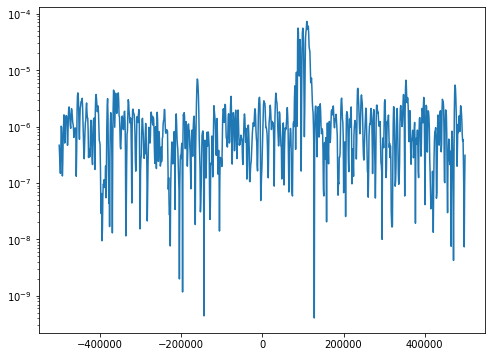

In [52]:
class Stft:
    
    def __init__(self, n=1024, window='flattop'):
        assert self.is_power2(n)
        self.n = n
        self.window = signal.get_window(window, self.n)
        
    def is_power2(self, n):
        '''Check least significant bit for power of two.'''
        return (n != 0) and (n & (n-1) == 0)
    
    def fft(self, sig, fs):
        '''Compute FFT and spectrum shifted to natural order.'''
        dt = 1./fs
        f = fft.fftshift(fft.fftfreq(len(sig), dt))
        s = fft.fftshift(fft.fft(sig))
        return f, s

    def apply_window(self, sig):
        return sig * self.window
    
    def stft_helper(self, sig, fs):
        return self.fft(self.apply_window(sig), fs)
    
    def stft(self, sig, fs):
        segs = [sig[i:i + self.n] for i in range(0, len(sig), self.n)]
        for seg in segs:
            if len(seg) != self.n:
                break
            f, x = self.stft_helper(seg, fs)
            yield f, x
            
    def apply_psd(self, sig, fs):
#         return np.abs(sig)**2. / (len(sig) * fs)
        return np.abs(sig)**2. / (fs * (self.window**2).sum())

    def dB(self, psd):
        return 10. * np.log10(psd)

    def psd(self, sig, fs):
        for f, x in self.stft(sig, fs):
            yield f, self.apply_psd(x, fs)
        
    def spectogram(self, sig, fs, dB=True):
        tl = list()
        xl = list()
        i = 0
        for f, x in self.psd(sig, fs):
            tl.append(i*self.n*1./fs)
            i += 1
            if dB:
                xl.append(self.dB(x))
            else:
                xl.append(x)
        xl = np.swapaxes(xl, 0, 1)
        return f, tl, xl


sft = Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(both, sample_frequency, False)

plt.figure(figsize=(8, 6))
plt.semilogy(f, x[:, 2])
# plt.plot(f, x[:, 2])
# plt.plot(150000, 10e-14, 'x')
plt.show()

# plt.figure(figsize=(8, 6))
# plt.pcolormesh(t,
#                f,
#                x,
#                shading='flat',
#                cmap='viridis',
#                snap=True,
#                vmin=np.min(x),
#                vmax=np.max(x))
# plt.title('STFT Magnitude')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.show()

In [53]:
class FreqED:
        
    def __init__(self, num_bands, fs, fft_len, f):
        self.num_bands = num_bands
        self.fft_len = fft_len
        self.di = fft_len / num_bands
        self.df = f[1] - f[0]
        self.fs = fs
        self.f = f
        assert self.df == (self.fs/self.fft_len)
        
    def energy(self, ps):
        return np.sum(np.abs(ps) ** 2)/self.fs
    
    def segs(self, ps):
        f_segs = list()
        ps_segs = list()
        for i in range(int(self.num_bands)):
            idx1 = int(i*self.di)
            idx2 = int((i+1)*self.di)
            f_segs.append(self.f[idx1:idx2])
            ps_segs.append(ps[idx1:idx2])
        return f_segs, ps_segs
    
    def detect(self, ps):
        f_segs, ps_segs = self.segs(ps)
        en_segs = list()
        for i in range(int(self.num_bands)):
            plt.figure(figsize=(8, 6))
            plt.semilogy(f_segs[i], ps_segs[i])
            plt.show()
            en_segs.append(self.energy(ps_segs[i]))
        return en_segs
    
    
ed = FreqED(num_bands=8, fs=s, fft_len=1024, f=f)
en = ed.detect(x[:, 2])

plt.figure(figsize=(8, 6))
plt.plot(en)
plt.show()

NameError: name 'fs' is not defined

In [ ]:
import scipy.ndimage

def clip_2d(x, lim_min, lim_max):
    (x, y) = np.shape(Sxx)
    for i in range(x):
        for j in range(y):
            Sxx[i, j] = max(min(Sxx[i, j], lim_max), lim_min)
    return Sxx

def smooth_2d(x, sigma):
    return scipy.ndimage.filters.gaussian_filter(x, [sigma, sigma], mode='mirror')

def crop_2d(Sxx, f, t, n):
    Sxx = Sxx[n:-n, n:-n]
    f = f[n:-n]
    t = t[n:-n]
    return Sxx, f, t

In [ ]:
f, t, Sxx = signal.spectrogram(both, fs, return_onesided=False, window='hann', nperseg=1024, nfft=1024, noverlap=0, detrend=False, scaling='density', mode='psd')

f = fft.fftshift(f)
Sxx = fft.fftshift(Sxx, axes=0)

Sxx = 10.0*np.log10(Sxx)
Sxx = clip_2d(Sxx, -60, 0)
Sxx = smooth_2d(Sxx, 2)
# Sxx, f, t = crop_2d(Sxx, f, t, 4)

fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')
# ax.get_proj = lambda: np.dot(mpl3d.axes3d.Axes3D.get_proj(ax), np.diag([1, 1, 0.5, 1]))
ax.plot_surface(f[:, None], t[None, :], Sxx, cmap='viridis', rstride=1, cstride=1, alpha=1, antialiased=True)
ax.view_init(elev=30, azim=70)
plt.show()
plt.savefig('test.png')  